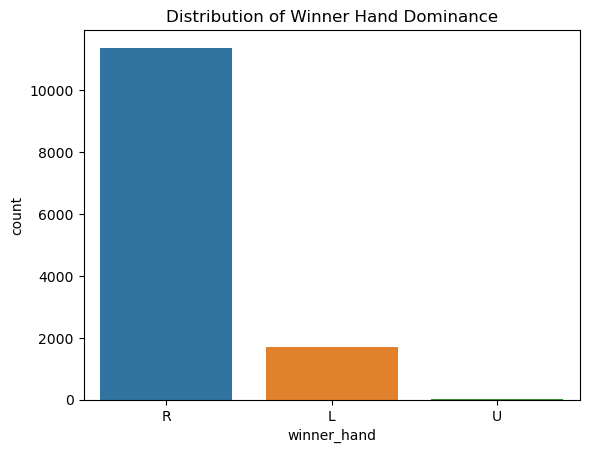

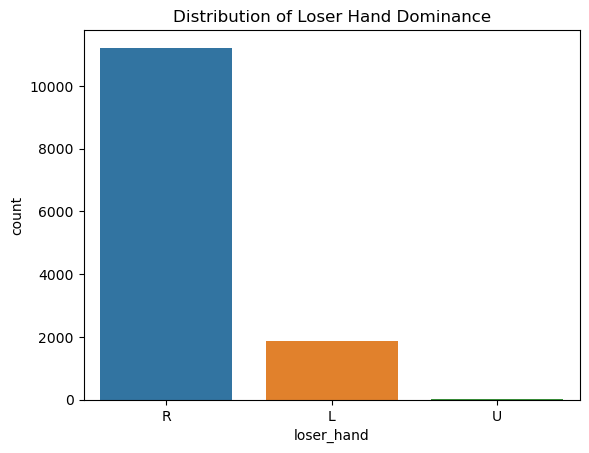

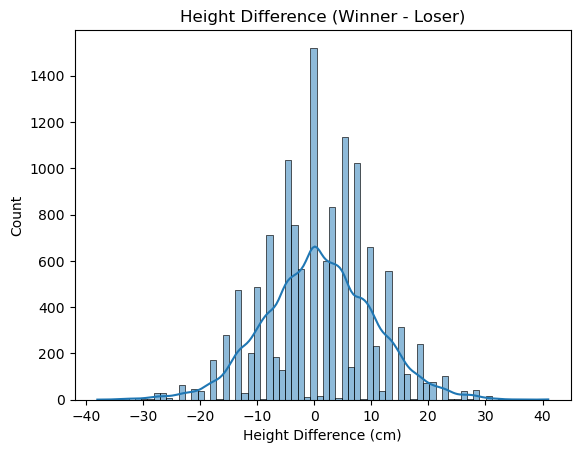

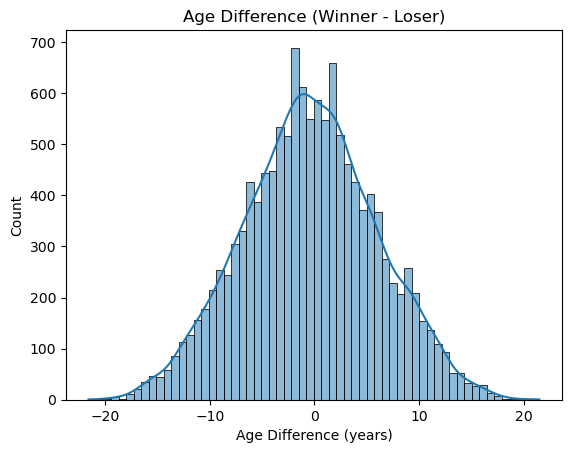

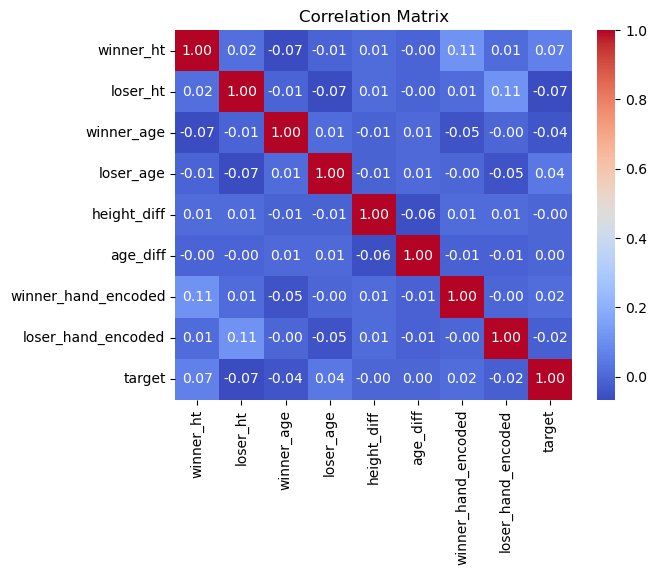

In [26]:
# Exploratory Data Analysis (EDA)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the datasets
data_2024 = pd.read_csv('atp_matches_2024.csv')
data_2023 = pd.read_csv('atp_matches_2023.csv')
data_2022 = pd.read_csv('atp_matches_2022.csv')
data_2021 = pd.read_csv('atp_matches_2021.csv')
data_2020 = pd.read_csv('atp_matches_2020.csv')
data_2019 = pd.read_csv('atp_matches_2019.csv')

# Combine datasets
data = pd.concat([data_2024, data_2023, data_2022, data_2021, data_2020, data_2019], ignore_index=True)

# Data Preprocessing for EDA
data = data.dropna(subset=['winner_hand', 'loser_hand', 'winner_ht', 'loser_ht', 'winner_age', 'loser_age',
                           'winner_rank', 'loser_rank', 'w_ace', 'l_ace', 'surface'])

# Analyze the distribution of hand dominance
sns.countplot(x=data['winner_hand'], order=data['winner_hand'].value_counts().index)
plt.title("Distribution of Winner Hand Dominance")
plt.show()

sns.countplot(x=data['loser_hand'], order=data['loser_hand'].value_counts().index)
plt.title("Distribution of Loser Hand Dominance")
plt.show()

# Analyze height and age differences between winners and losers
data['height_diff'] = data['winner_ht'] - data['loser_ht']
data['age_diff'] = data['winner_age'] - data['loser_age']

sns.histplot(data['height_diff'], kde=True)
plt.title("Height Difference (Winner - Loser)")
plt.xlabel("Height Difference (cm)")
plt.show()

sns.histplot(data['age_diff'], kde=True)
plt.title("Age Difference (Winner - Loser)")
plt.xlabel("Age Difference (years)")
plt.show()

# Correlation with Target Variable (Winner=1, Loser=0)
data['target'] = np.ones(len(data))
losing_data = data.copy()
losing_data[['winner_hand', 'loser_hand', 'winner_ht', 'loser_ht', 'winner_age', 'loser_age']] = losing_data[['loser_hand', 'winner_hand', 'loser_ht', 'winner_ht', 'loser_age', 'winner_age']]
losing_data['target'] = 0

data_combined = pd.concat([data, losing_data], ignore_index=True)

# Encode categorical variables for correlation analysis
data_combined['winner_hand_encoded'] = data_combined['winner_hand'].astype('category').cat.codes
data_combined['loser_hand_encoded'] = data_combined['loser_hand'].astype('category').cat.codes

correlation_features = ['winner_ht', 'loser_ht', 'winner_age', 'loser_age', 'height_diff', 'age_diff', 'winner_hand_encoded', 'loser_hand_encoded', 'target']
correlation_matrix = data_combined[correlation_features].corr()

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


C:\Users\dcjc9\AppData\Local\Temp\ipykernel_17248\3918012972.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  right_vs_left['normalized_count'] = right_vs_left['winner_hand'].map(hand_counts)


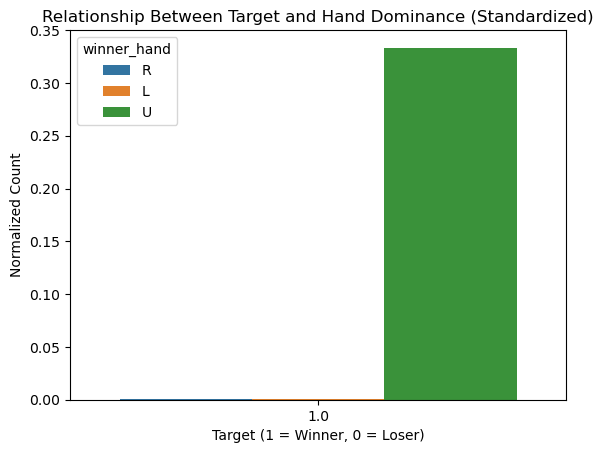

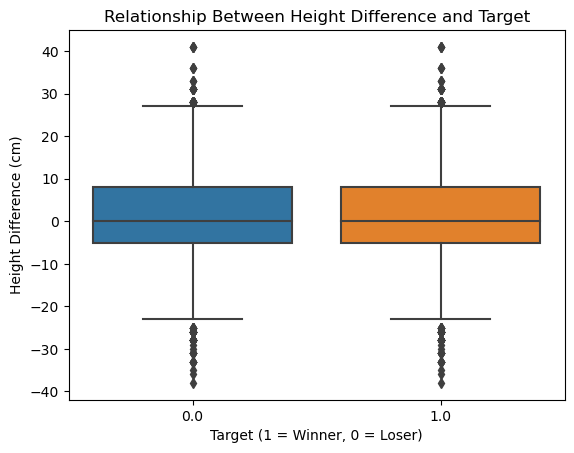

In [29]:
# Analyze the relationship between hand dominance and target (standardized by hand frequency)
right_vs_left = data[(data['winner_hand'] != data['loser_hand'])]
hand_counts = right_vs_left['winner_hand'].value_counts()
right_vs_left['normalized_count'] = right_vs_left['winner_hand'].map(hand_counts)

sns.barplot(x=right_vs_left['target'], y=1/right_vs_left['normalized_count'], hue=right_vs_left['winner_hand'])
plt.title("Relationship Between Target and Hand Dominance (Standardized)")
plt.xlabel("Target (1 = Winner, 0 = Loser)")
plt.ylabel("Normalized Count")
plt.show()

# Analyze the relationship between height difference and target
sns.boxplot(x=data_combined['target'], y=data_combined['height_diff'])
plt.title("Relationship Between Height Difference and Target")
plt.xlabel("Target (1 = Winner, 0 = Loser)")
plt.ylabel("Height Difference (cm)")
plt.show()

In [30]:
# Model Training
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler

# Feature Engineering
# Create features for both players
features = pd.DataFrame()
features['rank_diff'] = data['loser_rank'] - data['winner_rank']
features['aces_diff'] = data['w_ace'] - data['l_ace']
features['hand'] = data['winner_hand'].astype('category').cat.codes
features['surface'] = data['surface'].astype('category').cat.codes

# Target Variable
target = np.ones(len(data))  # Winner is 1

# Generate features for losing perspective (to balance classes)
losing_features = features.copy()
losing_features['rank_diff'] = -losing_features['rank_diff']
losing_features['aces_diff'] = -losing_features['aces_diff']
features['hand'] = data['loser_hand'].astype('category').cat.codes

target = pd.concat([pd.Series(target), pd.Series(np.zeros(len(data)))], ignore_index=True)
features = pd.concat([features, losing_features], ignore_index=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Standardize the features for certain algorithms
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models to compare
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Support Vector Machine": SVC(probability=True, random_state=42)
}

# Train and evaluate each model
results = []
for name, model in models.items():
    if name in ["Logistic Regression", "Support Vector Machine"]:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    results.append({"Model": name, "Accuracy": accuracy, "ROC AUC": roc_auc})

    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"ROC AUC: {roc_auc:.2f}")
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred))

# Display comparison of results
results_df = pd.DataFrame(results)
print("\nModel Comparison:\n")
print(results_df)


Random Forest Results:
Accuracy: 0.60
ROC AUC: 0.64

Classification Report:

              precision    recall  f1-score   support

         0.0       0.59      0.60      0.59      2557
         1.0       0.61      0.60      0.61      2674

    accuracy                           0.60      5231
   macro avg       0.60      0.60      0.60      5231
weighted avg       0.60      0.60      0.60      5231


Logistic Regression Results:
Accuracy: 0.66
ROC AUC: 0.71

Classification Report:

              precision    recall  f1-score   support

         0.0       0.65      0.66      0.65      2557
         1.0       0.67      0.66      0.66      2674

    accuracy                           0.66      5231
   macro avg       0.66      0.66      0.66      5231
weighted avg       0.66      0.66      0.66      5231


Support Vector Machine Results:
Accuracy: 0.65
ROC AUC: 0.70

Classification Report:

              precision    recall  f1-score   support

         0.0       0.64      0.66      0.6